In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null


In [2]:
!wget -q https://www-us.apache.org/dist/spark/spark-3.0.1/spark-3.0.1-bin-hadoop2.7.tgz


In [3]:
!tar xf spark-3.0.1-bin-hadoop2.7.tgz


In [4]:
!pip install -q findspark


In [5]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.1-bin-hadoop2.7"

In [7]:
import findspark
findspark.init()

In [8]:
findspark.find()


'/content/spark-3.0.1-bin-hadoop2.7'

In [9]:
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [10]:
import sys,tempfile, urllib
from pyspark.sql.functions import *

In [11]:
from pyspark import SparkContext, SparkConf
conf = SparkConf().setAppName("Health").setMaster("local[4]")  #local or hive
sc = SparkContext.getOrCreate(conf=conf) # if already running then get else get

In [12]:
from pyspark.sql import SparkSession   # if only SparkSession is needed
spark = SparkSession.builder.appName('Health').getOrCreate()

In [13]:
df = spark.read.csv("/content/health.csv", header = True)


In [14]:
df.describe()  #df.collect(), df.take(2)


DataFrame[summary: string, S.No.: string, State/ UT: string, Total Population in Rural Areas: string, Estimated Tribal Population in Rural Areas: string, Sub Centres - Required: string, Sub Centres - In Position: string, Sub Centres - Shortfall: string, Primary Health Centres (PHCs) - Required: string, Primary Health Centres (PHCs) - In Position: string, Primary Health Centres (PHCs) - Shortfall: string, Community Health Centres (CHCs) - Required: string, Community Health Centres (CHCs) - In Position: string, Community Health Centres (CHCs) - Shortfall: string]

In [15]:

# Renaming column names a/c to my wishes!
oldColumns = df.schema.names
newColumns = ["sn", "state", "population", "tribal_population", "sub_centres_req","sub_centres_present", \
              "sub_centres_short", "phc_req", "phc_present", "phc_short", "chc_req", "chc_present" \
             ,"chc_short"]

In [16]:
# Part of Renaming collumns
from functools import reduce
df = reduce(lambda data, idx: data.withColumnRenamed(oldColumns[idx], newColumns[idx]), range(len(oldColumns)),df)
df.printSchema()
df.show()

root
 |-- sn: string (nullable = true)
 |-- state: string (nullable = true)
 |-- population: string (nullable = true)
 |-- tribal_population: string (nullable = true)
 |-- sub_centres_req: string (nullable = true)
 |-- sub_centres_present: string (nullable = true)
 |-- sub_centres_short: string (nullable = true)
 |-- phc_req: string (nullable = true)
 |-- phc_present: string (nullable = true)
 |-- phc_short: string (nullable = true)
 |-- chc_req: string (nullable = true)
 |-- chc_present: string (nullable = true)
 |-- chc_short: string (nullable = true)

+---+-----------------+----------+-----------------+---------------+-------------------+-----------------+-------+-----------+---------+-------+-----------+---------+
| sn|            state|population|tribal_population|sub_centres_req|sub_centres_present|sub_centres_short|phc_req|phc_present|phc_short|chc_req|chc_present|chc_short|
+---+-----------------+----------+-----------------+---------------+-------------------+-----------------

In [17]:
# To use regex replace
import re
from pyspark.sql.functions import *

df1 = df after (1) removing ',' (2) Converting Surplus to 0 (3) Typing casting


In [18]:
df1 = df
from pyspark.sql.types import *
colnames = df1.schema.names
for i in colnames:
    colname = i
    df1 = df1.withColumn(colname, regexp_replace(colname, ",", ""))  #Removing spaces from data in columns
    df1 = df1.withColumn(colname, regexp_replace(colname, "Surplus", "0")) # Modyfying unwanted data
    if(colname!='state'):
        df1 = df1.withColumn(colname, col(colname).cast(IntegerType())) #Type casting

In [19]:
df.show()  # Orignal data frame
df1.show() # Data frame after : 1) Type casting 2) filtering Data
df1.printSchema()

+---+-----------------+----------+-----------------+---------------+-------------------+-----------------+-------+-----------+---------+-------+-----------+---------+
| sn|            state|population|tribal_population|sub_centres_req|sub_centres_present|sub_centres_short|phc_req|phc_present|phc_short|chc_req|chc_present|chc_short|
+---+-----------------+----------+-----------------+---------------+-------------------+-----------------+-------+-----------+---------+-------+-----------+---------+
|  1|   Andhra Pradesh|56,311,788|        4,723,312|         11,892|             12,522|          Surplus|  1,955|      1,624|      331|    488|        281|      207|
|  2|Arunachal Pradesh| 1,069,165|          744,996|            313|                286|               27|     48|         97|  Surplus|     12|         48|  Surplus|
|  3|            Assam|26,780,516|        3,638,841|          5,841|              4,604|            1,237|    953|        938|       15|    238|        108|      130

In [20]:
df1.registerTempTable("df1_table")


Query 1


In [21]:
#List of states that have  shortage of sub_centres , phc_centres and chc centres 
check = spark.sql("select state,sub_centres_short,phc_short,chc_short from df1_table where sub_centres_short>0 and phc_short>0 and chc_short>0 ")
(check).show()

+--------------------+-----------------+---------+---------+
|               state|sub_centres_short|phc_short|chc_short|
+--------------------+-----------------+---------+---------+
|               Assam|             1237|       15|      130|
|               Bihar|             8837|     1220|      700|
|             Gujarat|              660|      157|       15|
|             Haryana|              798|      107|       30|
|           Jharkhand|             2085|      634|       53|
|      Madhya Pradesh|             3445|      821|      161|
|         Maharashtra|             2830|      380|      182|
|              Punjab|              513|      131|       15|
|             Tripura|               41|       27|       15|
|       Uttar Pradesh|            10516|     1480|      778|
|         West Bengal|             2680|     1239|      189|
|Dadra & Nagar Haveli|                4|        2|        1|
|               Delhi|               42|        5|        3|
+--------------------+--

Query 2,3,4,5


In [22]:
# States with no shortage of sub_centres,phc,chc
check2 = spark.sql("select state from df1_table where sub_centres_short==0 and phc_short==0 and chc_short==0 ")
#Top 5 most populated states
check3 = spark.sql("select state,population from df1_table order by population desc limit 5")
#State with maximum tribal population
check4 = spark.sql("select state,tribal_population from df1_table order by tribal_population desc limit 1")

#all details of a Lakshadweep
check5 = spark.sql("select *  from df1_table where state='Lakshadweep'")
check5.show()

+---+-----------+----------+-----------------+---------------+-------------------+-----------------+-------+-----------+---------+-------+-----------+---------+
| sn|      state|population|tribal_population|sub_centres_req|sub_centres_present|sub_centres_short|phc_req|phc_present|phc_short|chc_req|chc_present|chc_short|
+---+-----------+----------+-----------------+---------------+-------------------+-----------------+-------+-----------+---------+-------+-----------+---------+
| 34|Lakshadweep|     14121|            13503|              4|                 14|                0|      0|          4|        0|      0|          3|        0|
+---+-----------+----------+-----------------+---------------+-------------------+-----------------+-------+-----------+---------+-------+-----------+---------+



In [23]:
check = check['sub_centres_short','phc_short','chc_short'] #filtering data
check.show()

+-----------------+---------+---------+
|sub_centres_short|phc_short|chc_short|
+-----------------+---------+---------+
|             1237|       15|      130|
|             8837|     1220|      700|
|              660|      157|       15|
|              798|      107|       30|
|             2085|      634|       53|
|             3445|      821|      161|
|             2830|      380|      182|
|              513|      131|       15|
|               41|       27|       15|
|            10516|     1480|      778|
|             2680|     1239|      189|
|                4|        2|        1|
|               42|        5|        3|
+-----------------+---------+---------+



In [24]:

# Plotting Graph 
import pandas
import matplotlib.pyplot as plt

In [25]:
import numpy as np


In [26]:
# Get current size
fig_size = plt.rcParams["figure.figsize"]
print("Current_size:", fig_size)
#Set figure width to 10 and height to 6
fig_size[0] = 10
fig_size[1] = 9
plt.rcParams["figure.figsize"]=  fig_size

Current_size: [6.0, 4.0]


In [27]:
df1_mod = df1.filter("sub_centres_short>=798")
df1_mod.show()

+---+--------------+----------+-----------------+---------------+-------------------+-----------------+-------+-----------+---------+-------+-----------+---------+
| sn|         state|population|tribal_population|sub_centres_req|sub_centres_present|sub_centres_short|phc_req|phc_present|phc_short|chc_req|chc_present|chc_short|
+---+--------------+----------+-----------------+---------------+-------------------+-----------------+-------+-----------+---------+-------+-----------+---------+
|  3|         Assam|  26780516|          3638841|           5841|               4604|             1237|    953|        938|       15|    238|        108|      130|
|  4|         Bihar|  92075028|           889200|          18533|               9696|             8837|   3083|       1863|     1220|    770|         70|      700|
|  8|       Haryana|  16531493|                0|           3306|               2508|              798|    551|        444|      107|    137|        107|       30|
| 11|     Jharkh

**Converting Dataframe (df1) to Pandas for plotting graph



In [28]:

df1_pd = df1_mod.toPandas()
# df2_pd["state"]
label = [i for i in df1_pd["state"]]
label
#OR
# label=[]
# for i in df2["state"]:
#     label.append(i)

['Assam',
 'Bihar',
 'Haryana',
 'Jharkhand',
 'Madhya Pradesh',
 'Maharashtra',
 'Odisha',
 'Uttar Pradesh',
 'West Bengal']

numpy.arange(index)
**1)returns Array of evenly spaced values from 0 to stop or from start to stop 2)used here to give x-cordinates to graph i.e 0, 1, 2 till all elements in the list 3)So in following line of plt.bar(index,df1_pd["sub_centres_short"] ) 4)first we give stream of abcissa, then set of ordinate.So we have passed an array of int first then we pass an array of values of "sub_centres_short 5)We have stored array of states in 'label' variable
6)plt.xlabel() : simply for labely x-axis 7)plt.ylabel(): for labeling y-axis 9)xticks(): For giving specs of bars of bar-graph index: array storing all s-co-ordinates label: array of states

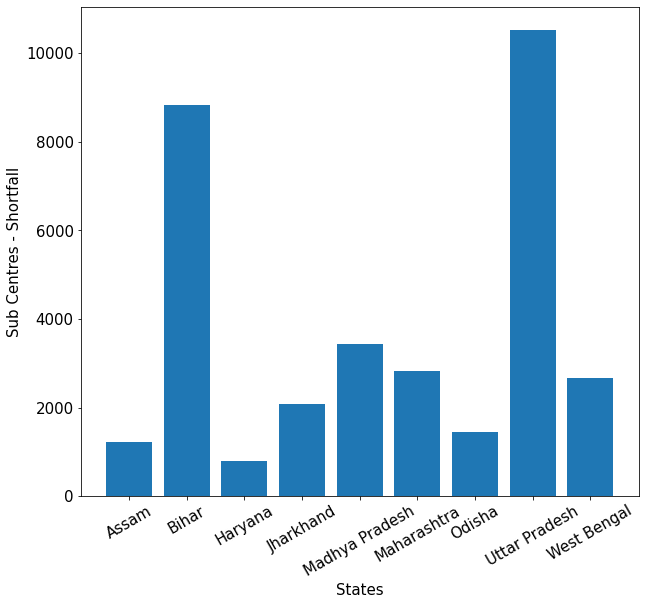

In [29]:
index=np.arange(len(label)) 
plt.bar(index, df1_pd["sub_centres_short"])  # Or change to df2
plt.xlabel("States",size=15)
plt.ylabel("Sub Centres - Shortfall", size=15)
plt.xticks(index, label, fontsize=15, rotation=30)
plt.yticks(fontsize = 15)
plt.show()

First analysis of sub_centre values
df2 = df with modified '_short' column i.e contains -ve , +ve values
It contains both surplus, and shortage values

In [30]:
df2 = df1
df2 = df2.withColumn('sub_centres_short', col('sub_centres_present')-col('sub_centres_req'))
df2 = df2.withColumn('phc_short', col('phc_present')-col('phc_req'))
df2 = df2.withColumn('chc_short', col('chc_present')-col('chc_req'))
df2.show()
df2.printSchema()

+---+-----------------+----------+-----------------+---------------+-------------------+-----------------+-------+-----------+---------+-------+-----------+---------+
| sn|            state|population|tribal_population|sub_centres_req|sub_centres_present|sub_centres_short|phc_req|phc_present|phc_short|chc_req|chc_present|chc_short|
+---+-----------------+----------+-----------------+---------------+-------------------+-----------------+-------+-----------+---------+-------+-----------+---------+
|  1|   Andhra Pradesh|  56311788|          4723312|          11892|              12522|              630|   1955|       1624|     -331|    488|        281|     -207|
|  2|Arunachal Pradesh|   1069165|           744996|            313|                286|              -27|     48|         97|       49|     12|         48|       36|
|  3|            Assam|  26780516|          3638841|           5841|               4604|            -1237|    953|        938|      -15|    238|        108|     -130

In [31]:
df2_surplus = df2.filter("sub_centres_short>=0")
df2_surplus.printSchema()

root
 |-- sn: integer (nullable = true)
 |-- state: string (nullable = true)
 |-- population: integer (nullable = true)
 |-- tribal_population: integer (nullable = true)
 |-- sub_centres_req: integer (nullable = true)
 |-- sub_centres_present: integer (nullable = true)
 |-- sub_centres_short: integer (nullable = true)
 |-- phc_req: integer (nullable = true)
 |-- phc_present: integer (nullable = true)
 |-- phc_short: integer (nullable = true)
 |-- chc_req: integer (nullable = true)
 |-- chc_present: integer (nullable = true)
 |-- chc_short: integer (nullable = true)



In [32]:

#Now removing negative sign also
    
df2_shortage= df2.filter("sub_centres_short<0") #Initialising 

from pyspark.sql.types import *
colnames = df2_shortage.schema.names
for i in colnames:
    colname = i
    if(colname=='sub_centres_short'):
        df2_shortage = df2_shortage.withColumn(colname, regexp_replace(colname, "-", ""))  #Removing spaces from data in columns
        df2_shortage = df2_shortage.withColumn(colname, col(colname).cast(IntegerType())) #Type casting
df2_shortage.printSchema()

root
 |-- sn: integer (nullable = true)
 |-- state: string (nullable = true)
 |-- population: integer (nullable = true)
 |-- tribal_population: integer (nullable = true)
 |-- sub_centres_req: integer (nullable = true)
 |-- sub_centres_present: integer (nullable = true)
 |-- sub_centres_short: integer (nullable = true)
 |-- phc_req: integer (nullable = true)
 |-- phc_present: integer (nullable = true)
 |-- phc_short: integer (nullable = true)
 |-- chc_req: integer (nullable = true)
 |-- chc_present: integer (nullable = true)
 |-- chc_short: integer (nullable = true)



In [33]:
df2_surplus_pd  = df2_surplus.toPandas()

# df2_shortage = df2_shortage["sub_centres_short"]
df2_shortage_pd = df2_shortage.toPandas()

label1 = [i for i in df2_surplus_pd["state"]]
label2 = [i for i in df2_shortage_pd["state"]]

# label1
# label2

**Ploting graph of df2_surplus



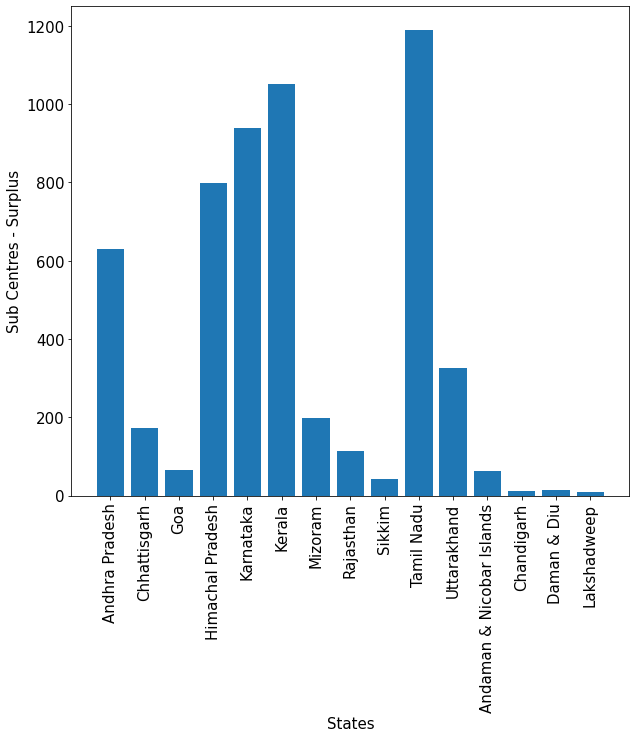

In [34]:
index=np.arange(len(label1)) 
plt.bar(index, df2_surplus_pd["sub_centres_short"])  # Or change to df2
plt.xlabel("States",size=15)
plt.ylabel("Sub Centres - Surplus", size=15)
plt.xticks(index, label1, fontsize=15, rotation=90)
plt.yticks(fontsize = 15)
plt.show()

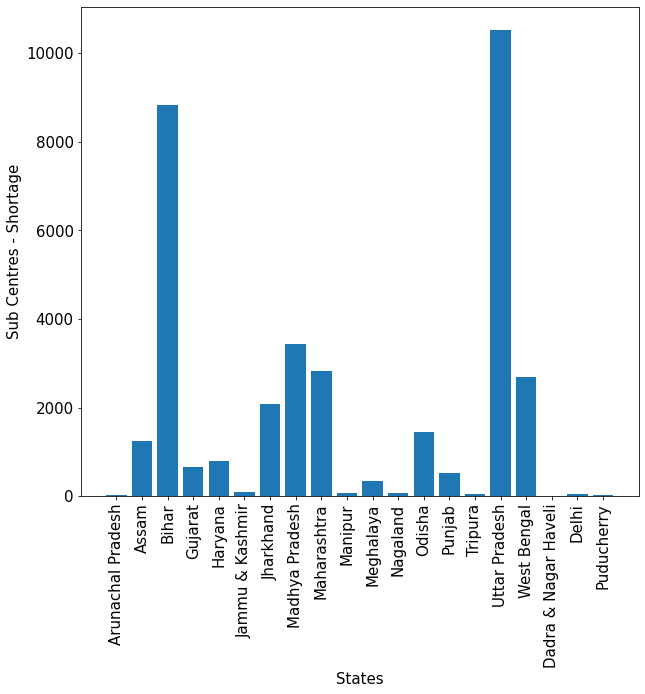

In [35]:

index=np.arange(len(label2)) 
plt.bar(index, df2_shortage_pd["sub_centres_short"])  # Or change to df2
plt.xlabel("States",size=15)
plt.ylabel("Sub Centres - Shortage", size=15)
plt.xticks(index, label2, fontsize=15, rotation=90)
plt.yticks(fontsize = 15)
plt.show()





Now analysis of phc values
df2 = df with modified '_short' column i.e contains -ve , +ve values
It contains both surplus, and shortage values
REPEATING ABOVE STEPS
**breaking df2 into two data frames: (1)surplus (2)shortage Also removing negative sign from shortage

In [36]:
df2_surplus = df2.filter("phc_short>=0")
df2_surplus.printSchema()

root
 |-- sn: integer (nullable = true)
 |-- state: string (nullable = true)
 |-- population: integer (nullable = true)
 |-- tribal_population: integer (nullable = true)
 |-- sub_centres_req: integer (nullable = true)
 |-- sub_centres_present: integer (nullable = true)
 |-- sub_centres_short: integer (nullable = true)
 |-- phc_req: integer (nullable = true)
 |-- phc_present: integer (nullable = true)
 |-- phc_short: integer (nullable = true)
 |-- chc_req: integer (nullable = true)
 |-- chc_present: integer (nullable = true)
 |-- chc_short: integer (nullable = true)



**The plot showed a problem that the Y axis is not ordered. : SOLUTION: Since data type was strings , so type cast it to int



In [37]:
#Now removing negative sign also
    
df2_shortage= df2.filter("phc_short<0") #Initialising 

from pyspark.sql.types import *
colnames = df2_shortage.schema.names
for i in colnames:
    colname = i
    if(colname=='phc_short'):
        df2_shortage = df2_shortage.withColumn(colname, regexp_replace(colname, "-", ""))  #Removing spaces from data in columns
        df2_shortage = df2_shortage.withColumn(colname, col(colname).cast(IntegerType())) #Type casting
df2_shortage.printSchema()

root
 |-- sn: integer (nullable = true)
 |-- state: string (nullable = true)
 |-- population: integer (nullable = true)
 |-- tribal_population: integer (nullable = true)
 |-- sub_centres_req: integer (nullable = true)
 |-- sub_centres_present: integer (nullable = true)
 |-- sub_centres_short: integer (nullable = true)
 |-- phc_req: integer (nullable = true)
 |-- phc_present: integer (nullable = true)
 |-- phc_short: integer (nullable = true)
 |-- chc_req: integer (nullable = true)
 |-- chc_present: integer (nullable = true)
 |-- chc_short: integer (nullable = true)



In [38]:
df2_surplus_pd  = df2_surplus.toPandas()

# df2_shortage = df2_shortage["sub_centres_short"]
df2_shortage_pd = df2_shortage.toPandas()

label1 = [i for i in df2_surplus_pd["state"]]
label2 = [i for i in df2_shortage_pd["state"]]

# label1
# label2

**Ploting graph of df2_surplus



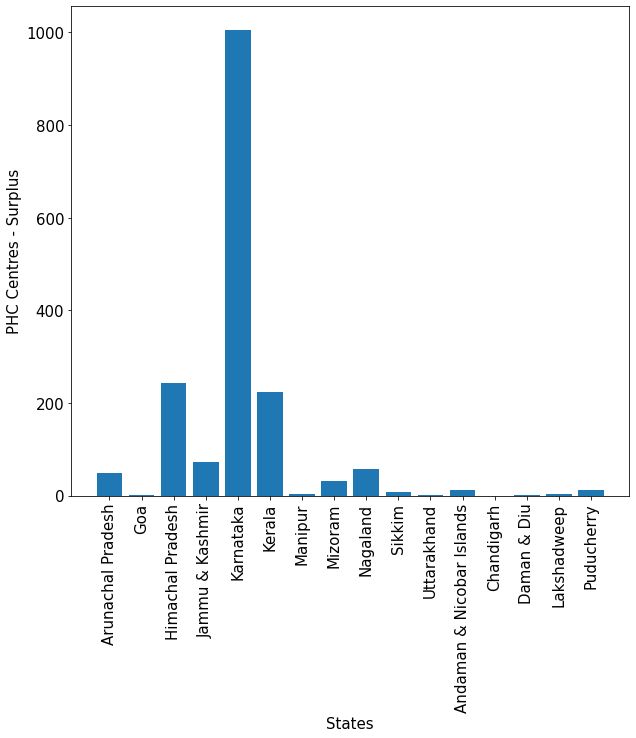

In [39]:
index=np.arange(len(label1)) 
plt.bar(index, df2_surplus_pd["phc_short"])  # Or change to df2
plt.xlabel("States",size=15)
plt.ylabel("PHC Centres - Surplus", size=15)
plt.xticks(index, label1, fontsize=15, rotation=90)
plt.yticks(fontsize = 15)
plt.show()

**Ploting graph of df2_shortage



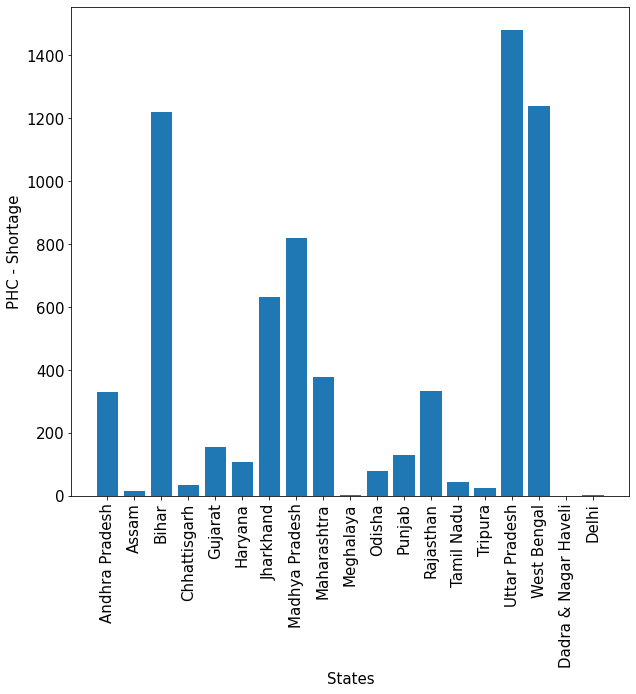

In [40]:
index=np.arange(len(label2)) 
plt.bar(index, df2_shortage_pd["phc_short"])  # Or change to df2
plt.xlabel("States",size=15)
plt.ylabel("PHC - Shortage", size=15)
plt.xticks(index, label2, fontsize=15, rotation=90)
plt.yticks(fontsize = 15)
plt.show()




Now analysis of chc values
df2 = df with modified '_short' column i.e contains -ve , +ve values
It contains both surplus, and shortage values
REPEATING ABOVE STEPS
**breaking df2 into two data frames: (1)surplus (2)shortage Also removing negative sign from shortage

In [41]:
df2_surplus = df2.filter("chc_short>=0")
df2_surplus.printSchema()

root
 |-- sn: integer (nullable = true)
 |-- state: string (nullable = true)
 |-- population: integer (nullable = true)
 |-- tribal_population: integer (nullable = true)
 |-- sub_centres_req: integer (nullable = true)
 |-- sub_centres_present: integer (nullable = true)
 |-- sub_centres_short: integer (nullable = true)
 |-- phc_req: integer (nullable = true)
 |-- phc_present: integer (nullable = true)
 |-- phc_short: integer (nullable = true)
 |-- chc_req: integer (nullable = true)
 |-- chc_present: integer (nullable = true)
 |-- chc_short: integer (nullable = true)



**The plot showed a problem that the Y axis is not ordered. : SOLUTION: Since data type was strings , so type cast it to int



In [42]:
#Now removing negative sign also
    
df2_shortage= df2.filter("chc_short<0") #Initialising 

from pyspark.sql.types import *
colnames = df2_shortage.schema.names
for i in colnames:
    colname = i
    if(colname=='chc_short'):
        df2_shortage = df2_shortage.withColumn(colname, regexp_replace(colname, "-", ""))  #Removing spaces from data in columns
        df2_shortage = df2_shortage.withColumn(colname, col(colname).cast(IntegerType())) #Type casting
df2_shortage.printSchema()

root
 |-- sn: integer (nullable = true)
 |-- state: string (nullable = true)
 |-- population: integer (nullable = true)
 |-- tribal_population: integer (nullable = true)
 |-- sub_centres_req: integer (nullable = true)
 |-- sub_centres_present: integer (nullable = true)
 |-- sub_centres_short: integer (nullable = true)
 |-- phc_req: integer (nullable = true)
 |-- phc_present: integer (nullable = true)
 |-- phc_short: integer (nullable = true)
 |-- chc_req: integer (nullable = true)
 |-- chc_present: integer (nullable = true)
 |-- chc_short: integer (nullable = true)



**Converting Dataframe (df2) to Pandas for plotting graph



In [44]:
df2_surplus_pd  = df2_surplus.toPandas()

# df2_shortage = df2_shortage["sub_centres_short"]
df2_shortage_pd = df2_shortage.toPandas()

label1 = [i for i in df2_surplus_pd["state"]]
label2 = [i for i in df2_shortage_pd["state"]]

# label1
# label2

**Ploting graph of df2_surplus



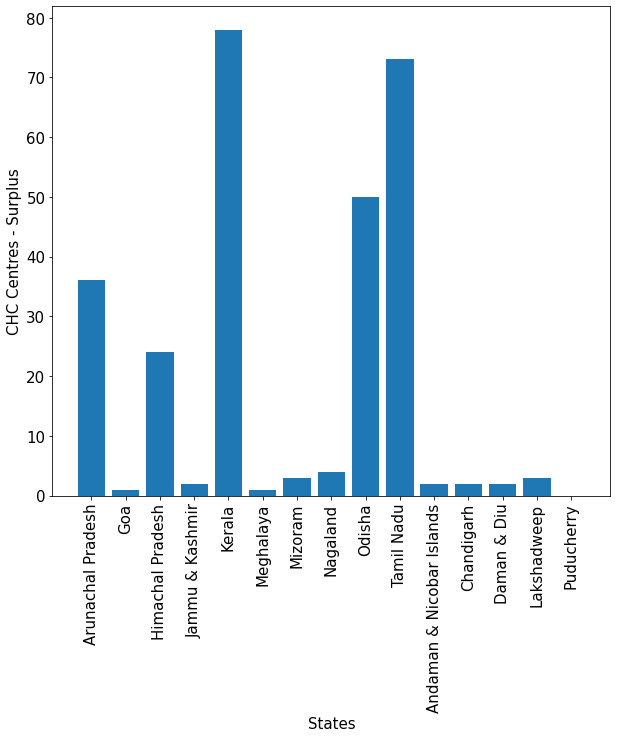

In [45]:
index=np.arange(len(label1)) 
plt.bar(index, df2_surplus_pd["chc_short"])  # Or change to df2
plt.xlabel("States",size=15)
plt.ylabel("CHC Centres - Surplus", size=15)
plt.xticks(index, label1, fontsize=15, rotation=90)
plt.yticks(fontsize = 15)
plt.show()

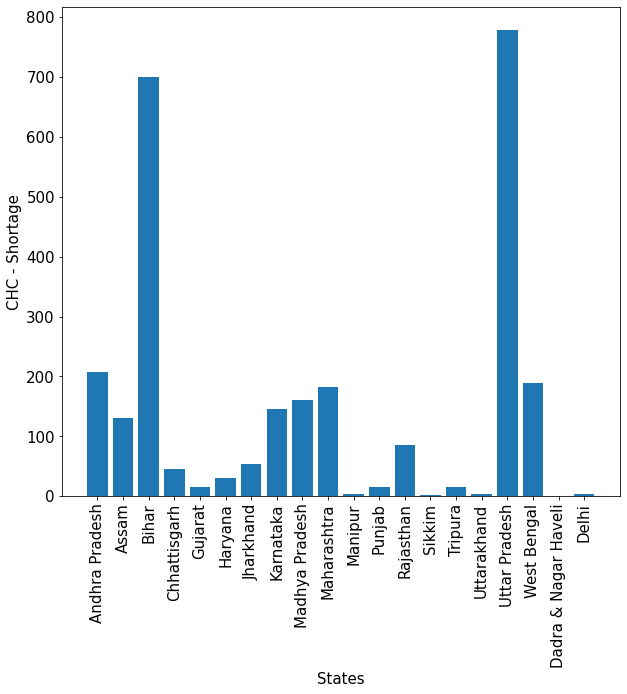

In [46]:

index=np.arange(len(label2)) 
plt.bar(index, df2_shortage_pd["chc_short"])  # Or change to df2
plt.xlabel("States",size=15)
plt.ylabel("CHC - Shortage", size=15)
plt.xticks(index, label2, fontsize=15, rotation=90)
plt.yticks(fontsize = 15)
plt.show()
